In [1]:
import scanpy as sc
import scIB
import pandas as pd
import numpy as np
import scipy as sp

In [36]:
# Load concatenated data object
adata = sc.read('Lung_atlas_full.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 47291 × 15148 
    obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type'

In [92]:
adata.obs['orig.ident'].value_counts()

ARMS051    8932
ARMS054    6311
296C       3772
ARMS052    3470
302C       3342
ASK440     3314
ASK452     2485
298C       2445
ASK454     2372
ASK428     2189
290B       1991
ARMS026    1854
ARMS032    1459
ARMS038    1229
284C        959
ARMS040     705
292B        462
Name: orig.ident, dtype: int64

Plan:
1. Normalize the data
2. Sparsify the expression matrix
3. Run rank genes groups over annotations
4. Do annotation overlaps

In [6]:
pd.crosstab(adata.obs['location'], adata.obs['protocol'])
pd.crosstab(adata.obs['location'], adata.obs['patientGroup'])

protocol,drop-seq,10x v2
location,,
Biopsy,0,10108
Dropseq_lower,5503,0
Dropseq_resection,4857,0
Lung_brush,0,6765
Nasal_brush,0,7087
Transplant,0,12971


patientGroup,Ctrl,Parenchyma,nan
location,,,
Biopsy,10108,0,0
Dropseq_lower,0,0,5503
Dropseq_resection,0,0,4857
Lung_brush,6765,0,0
Nasal_brush,7087,0,0
Transplant,0,12971,0


In [37]:
adata.obs['dataset'] = ['Dropseq_transplant' if loc.startswith('Dropseq') else '10x_'+loc for loc in adata.obs['location']]

In [38]:
adata.obs['dataset'].value_counts()

10x_Transplant        12971
Dropseq_transplant    10360
10x_Biopsy            10108
10x_Nasal_brush        7087
10x_Lung_brush         6765
Name: dataset, dtype: int64

Use this as a batch for normalization. It is likely that there are different cell types between these datasets.

... storing 'dataset' as categorical


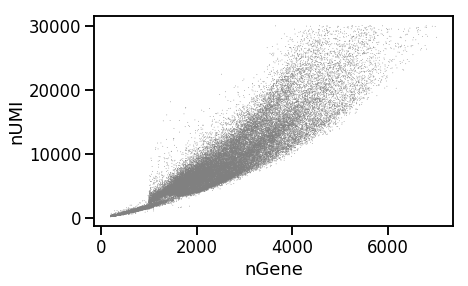

In [10]:
sc.pl.scatter(adata, 'nGene', 'nUMI')

In [14]:
scIB.utils.checkBatch('dataset', adata.obs)

In [15]:
datasets = scIB.utils.splitBatches(adata, 'dataset')

In [17]:
datasets = [i.copy() for i in datasets]

In [18]:
datasets

[AnnData object with n_obs × n_vars = 10360 × 15148 
     obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'dataset',
 AnnData object with n_obs × n_vars = 10108 × 15148 
     obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'dataset',
 AnnData object with n_obs × n_vars = 7087 × 15148 
     obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'dataset',
 AnnData object with n_obs × n_vars = 676

# 1. Normalization

In [19]:
for dat in datasets:
    scIB.pp.normalize(dat)

/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size

In [40]:
adata_full = datasets[0].concatenate(*datasets[1:], batch_key='dataset')

In [41]:
adata
adata_full

AnnData object with n_obs × n_vars = 47291 × 15148 
    obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'dataset'

AnnData object with n_obs × n_vars = 47291 × 15148 
    obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'dataset', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'size_factors'
    layers: 'counts'

In [42]:
adata.obs['dataset'].value_counts()

10x_Transplant        12971
Dropseq_transplant    10360
10x_Biopsy            10108
10x_Nasal_brush        7087
10x_Lung_brush         6765
Name: dataset, dtype: int64

In [43]:
pd.crosstab(adata_full.obs.dataset, adata_full.obs.location)

location,Biopsy,Dropseq_lower,Dropseq_resection,Lung_brush,Nasal_brush,Transplant
dataset,,,,,,
0,0,5503,4857,0,0,0
1,10108,0,0,0,0,0
2,0,0,0,0,7087,0
3,0,0,0,6765,0,0
4,0,0,0,0,0,12971


In [44]:
adata_full.rename_categories('dataset', ['Dropseq_transplant', '10x_Biopsy', '10x_Nasal_brush', '10x_Lung_brush', '10x_Transplant'])

In [45]:
pd.crosstab(adata_full.obs.dataset, adata_full.obs.location)

location,Biopsy,Dropseq_lower,Dropseq_resection,Lung_brush,Nasal_brush,Transplant
dataset,,,,,,
Dropseq_transplant,0,5503,4857,0,0,0
10x_Biopsy,10108,0,0,0,0,0
10x_Nasal_brush,0,0,0,0,7087,0
10x_Lung_brush,0,0,0,6765,0,0
10x_Transplant,0,0,0,0,0,12971


In [94]:
adata_full.obs['sampling_method'] = ['Transplant' if dat.endswith('ransplant') else 'Brush' if dat.endswith('brush') else dat.split('_')[1] for dat in adata_full.obs['dataset']]

In [95]:
adata_full.obs['sampling_method'].value_counts()

Transplant    23331
Brush         13852
Biopsy        10108
Name: sampling_method, dtype: int64

# 2. Marker genes

In [48]:
pd.crosstab(adata.obs['celltype'], adata.obs['protocol'])

protocol,drop-seq,10x v2
celltype,,
Alveolar_Macrophage_Chitinase_Positive,0,1855
Alveolar_Macrophage_Defensin_Positive,0,2168
B cell,1250,0
B_Cells,0,114
Basal 1,0,2095
Basal 2,0,3839
Ciliated,433,6706
Ciliated(Nasal),0,1555
Club,0,3487


In [93]:
pd.crosstab(adata.obs['celltype'], adata.obs['location'])

location,Biopsy,Dropseq_lower,Dropseq_resection,Lung_brush,Nasal_brush,Transplant
celltype,,,,,,
Alveolar_Macrophage_Chitinase_Positive,0,0,0,3,0,1852
Alveolar_Macrophage_Defensin_Positive,24,0,0,48,0,2096
B cell,0,22,1228,0,0,0
B_Cells,51,0,0,10,1,52
Basal 1,1970,0,0,121,2,2
Basal 2,3065,0,0,714,53,7
Ciliated,2580,292,141,3973,11,142
Ciliated(Nasal),25,0,0,15,1513,2
Club,1741,0,0,1731,3,12


Only 1 celltype label overlaps here. Use protocol split to map between labels

In [49]:
datasets_ct = scIB.utils.splitBatches(adata_full, 'protocol')

In [51]:
datasets_ct = [i.copy() for i in datasets_ct]
datasets_ct

[AnnData object with n_obs × n_vars = 10360 × 15148 
     obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'dataset', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'size_factors'
     layers: 'counts', AnnData object with n_obs × n_vars = 36931 × 15148 
     obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'dataset', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'size_factors'
     layers: 'counts']

In [56]:
sc.tl.rank_genes_groups(datasets_ct[0], groupby='celltype', key_added='celltype_markers')
sc.tl.rank_genes_groups(datasets_ct[1], groupby='celltype', key_added='celltype_markers')

... storing 'celltype' as categorical
... storing 'celltype_T1' as categorical
... storing 'location' as categorical
... storing 'orig.ident' as categorical
... storing 'patientGroup' as categorical
... storing 'protocol' as categorical
... storing 'reordered_cell_types' as categorical
... storing 'sanger_type' as categorical


In [66]:
#Get dict of one celltype makers for marker_gene_overlaps function
cts = datasets_ct[0].obs['celltype'].cat.categories.tolist()
marker_dict0 = {ct:datasets_ct[0].uns['celltype_markers']['names'][ct] for ct in cts}

In [67]:
marker_dict0.keys()

dict_keys(['B cell', 'Ciliated', 'Endothelium', 'Fibroblast', 'Lymphatic', 'Macrophages', 'Mast cell', 'NK cell', 'Secretory', 'T cell', 'Transformed epithelium', 'Type 1', 'Type 2'])

In [60]:
import seaborn as sns

In [73]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=(8,8)

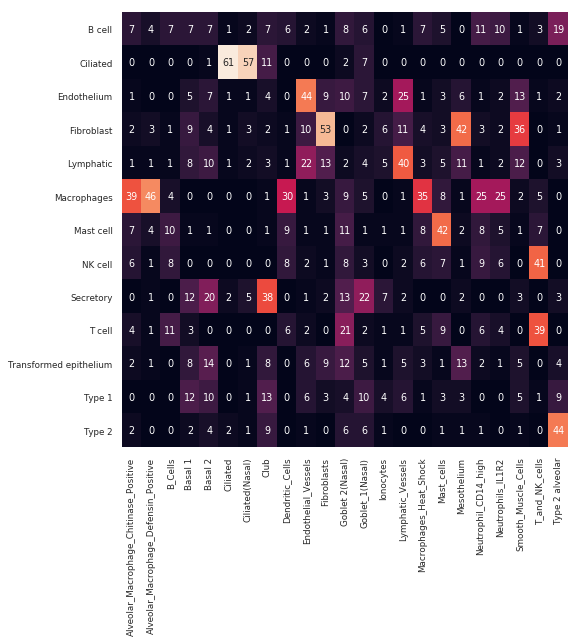

In [74]:
sns.set(font_scale=0.8)
sns.heatmap(sc.tl.marker_gene_overlap(datasets_ct[1], marker_dict0, key='celltype_markers'), cbar=False, annot=True, )

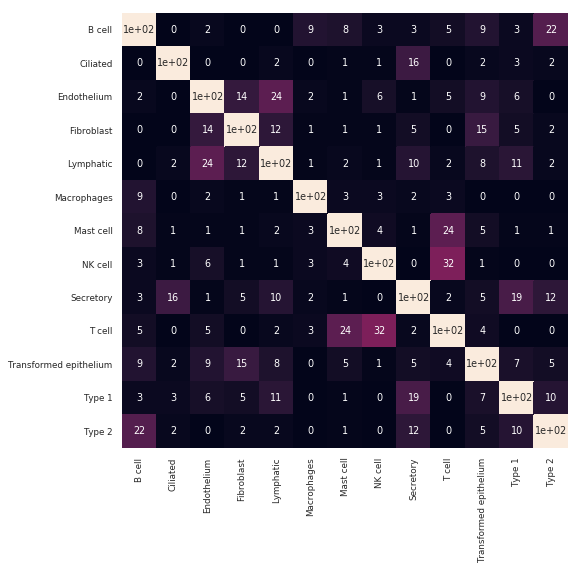

In [75]:
sns.set(font_scale=0.8)
sns.heatmap(sc.tl.marker_gene_overlap(datasets_ct[0], marker_dict0, key='celltype_markers'), cbar=False, annot=True, )

In [76]:
#Get dict of one celltype makers for marker_gene_overlaps function
cts = datasets_ct[1].obs['celltype'].cat.categories.tolist()
marker_dict1 = {ct:datasets_ct[1].uns['celltype_markers']['names'][ct] for ct in cts}

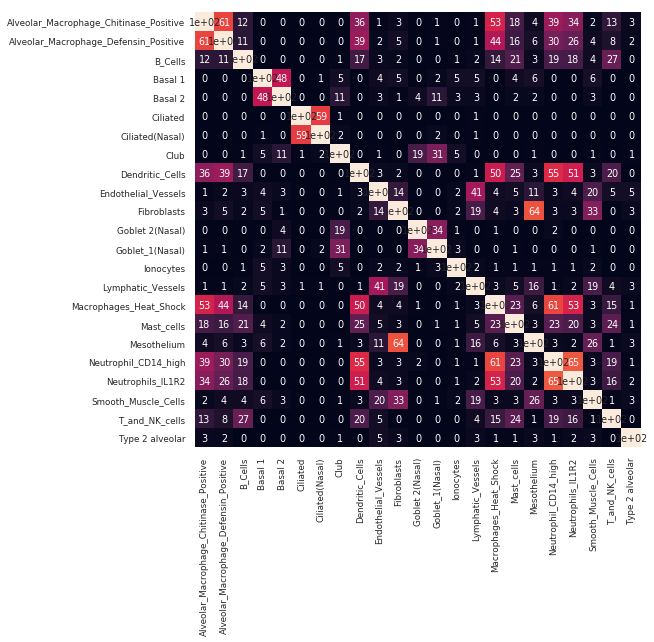

In [78]:
sns.set(font_scale=0.8)
sns.heatmap(sc.tl.marker_gene_overlap(datasets_ct[1], marker_dict1, key='celltype_markers'), cbar=False, annot=True, )

Label mappings:
- B_Cells -> B cell
- Fibroblasts -> Fibroblast
- Mast_cells -> Mast cell
- T cell -> T/NK cell
- NK cell -> T/NK cell
- T_and_NK_cells -> T/NK cell
- Macrophages_Heat_Shock -> Macrophage
- Alveolar_Macrophage_Chitinase_Positive -> Macrophage
- Alveolar_Macrophage_Defensin_Positive -> Macrophage
- Macrophages -> Macrophage


- Lymphatic = Lymphatic vessels?
- Endothelium = Endothelial vessels?
- Type 2 = Type 2 alveolar?
- Ciliated(Nasal) = Ciliated?

- Mesothelium?
- Secretory?
- Transformed epithelium?

Unique cell types:
- Goblet_1(Nasal)
- Goblet 2(Nasal)
- Club
- Dendritic_Cells
- Ionocytes
- Neutrophil_CD14_high
- Neutrophils_IL1R2
- Smooth_Muscle_Cells
- Type 1

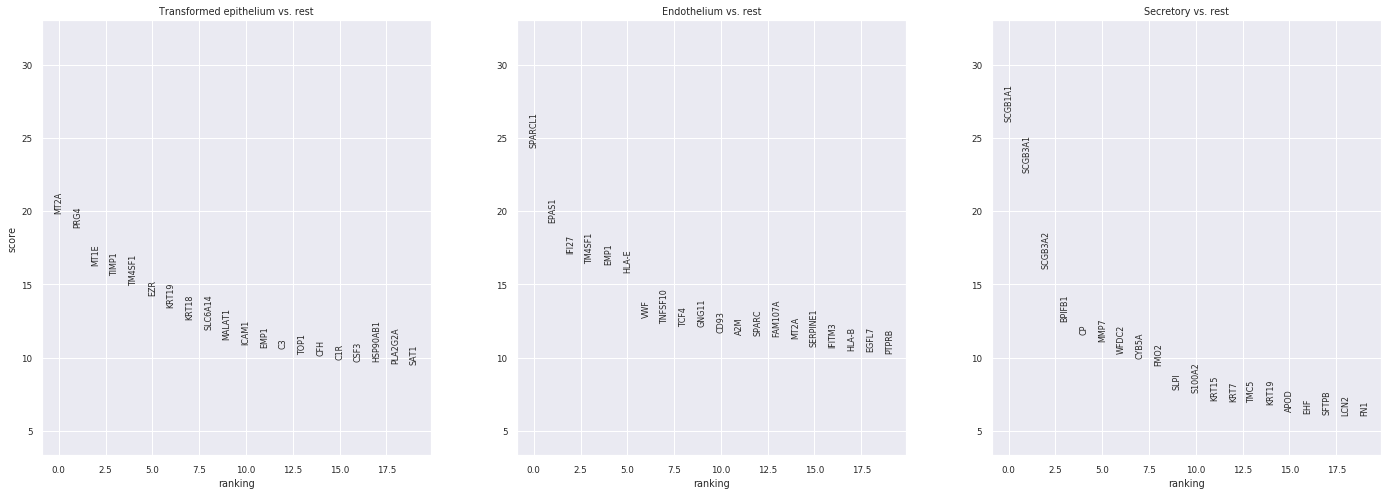

In [81]:
sc.pl.rank_genes_groups(datasets_ct[0], groups=['Transformed epithelium', 'Endothelium', 'Secretory'], key='celltype_markers')

# Cell type merging

Notes:
- join all macrophages
- neutrophils different from macrophages
- type 2 = type 2 alveolar
- secretory = goblet & club cells (also basal cells?)
  - goblet cells are nasal, can separate from secretory transplant cells!
- smooth muscle = endothelium?

Neutrophils:
- confirmed unique, as similar to macrophages in both datasets (not only macrophages in 1)



Notes: after talking to data generator (kudos to Herbert Schiller)
- remove transformed epithelium cells (not well annotated)
- remove nasal sample (and nasal cell types)
- secretory = club
- remove mesothelium
- remove smooth muscle cells (as likely fibroblast overlap for schiller lab labels)

In [97]:
pd.crosstab(adata_full.obs['patientGroup'], adata_full.obs['location'])

location,Biopsy,Dropseq_lower,Dropseq_resection,Lung_brush,Nasal_brush,Transplant
patientGroup,,,,,,
Ctrl,10108,0,0,6765,7087,0
Parenchyma,0,0,0,0,0,12971
nan,0,5503,4857,0,0,0


In [107]:
# Remove cell types and datasets
adata_full = adata_full[[i not in ['Nasal_brush'] for i in adata_full.obs['location']]]
adata_full = adata_full[[i not in ['Mesothelium', 'Transformed epithelium', 'Ciliated(Nasal)', 'Goblet_1(Nasal)', 'Goblet 2(Nasal)', 'Smooth_Muscle_Cells'] for i in adata_full.obs['celltype']]]

In [108]:
pd.crosstab(adata_full.obs['celltype'], adata_full.obs['location'])

location,Biopsy,Dropseq_lower,Dropseq_resection,Lung_brush,Transplant
celltype,,,,,
Alveolar_Macrophage_Chitinase_Positive,0,0,0,3,1852
Alveolar_Macrophage_Defensin_Positive,24,0,0,48,2096
B cell,0,22,1228,0,0
B_Cells,51,0,0,10,52
Basal 1,1970,0,0,121,2
Basal 2,3065,0,0,714,7
Ciliated,2580,292,141,3973,142
Club,1741,0,0,1731,12
Dendritic_Cells,195,0,0,108,1172


In [111]:
# Rename the labels
tmp = adata_full.obs['celltype']
tmp = ['Macrophage' if ct in ['Macrophages_Heat_Shock', 'Alveolar_Macrophage_Chitinase_Positive', 'Alveolar_Macrophage_Defensin_Positive', 'Macrophages'] else ct for ct in tmp]
tmp = ['T/NK cell' if ct in ['T cell', 'NK cell', 'T_and_NK_cells'] else ct for ct in tmp]
tmp = ['B cell' if ct in ['B_Cells'] else ct for ct in tmp]
tmp = ['Fibroblast' if ct in ['Fibroblasts'] else ct for ct in tmp]
tmp = ['Mast cell' if ct in ['Mast_cells'] else ct for ct in tmp]
tmp = ['Lymphatic' if ct in ['Lymphatic_Vessels'] else ct for ct in tmp]
tmp = ['Endothelium' if ct in ['Endothelial_Vessels'] else ct for ct in tmp]
tmp = ['Type 2' if ct in ['Type 2 alveolar'] else ct for ct in tmp]
tmp = ['Secretory' if ct in ['Club'] else ct for ct in tmp]
tmp = ['Dendritic cell' if ct in ['Dendritic_Cells'] else ct for ct in tmp]

In [112]:
np.unique(tmp)

array(['B cell', 'Basal 1', 'Basal 2', 'Ciliated', 'Dendritic cell',
       'Endothelium', 'Fibroblast', 'Ionocytes', 'Lymphatic',
       'Macrophage', 'Mast cell', 'Neutrophil_CD14_high',
       'Neutrophils_IL1R2', 'Secretory', 'T/NK cell', 'Type 1', 'Type 2'],
      dtype='<U20')

In [113]:
adata_full.obs['celltype_final'] = tmp

Trying to set attribute `.obs` of view, making a copy.


In [114]:
pd.crosstab(adata_full.obs['celltype_final'], adata_full.obs['dataset'])

dataset,Dropseq_transplant,10x_Biopsy,10x_Lung_brush,10x_Transplant
celltype_final,,,,
B cell,1250,51,10,52
Basal 1,0,1970,121,2
Basal 2,0,3065,714,7
Ciliated,433,2580,3973,142
Dendritic cell,0,195,108,1172
Endothelium,360,310,0,318
Fibroblast,204,51,0,478
Ionocytes,0,46,24,0
Lymphatic,195,2,0,144


In [115]:
pd.crosstab(adata_full.obs['celltype_final'], adata_full.obs['orig.ident'])

orig.ident,284C,290B,292B,296C,298C,302C,ARMS026,ARMS032,ARMS038,ARMS040,ARMS051,ARMS052,ARMS054,ASK428,ASK440,ASK452,ASK454
celltype_final,,,,,,,,,,,,,,,,,
B cell,9,11,3,4,23,2,5,3,1,1,31,4,16,6,16,17,1211
Basal 1,0,0,0,0,2,0,530,485,260,218,13,100,485,0,0,0,0
Basal 2,0,4,0,2,1,0,355,353,200,157,1639,367,708,0,0,0,0
Ciliated,0,65,12,8,57,0,488,346,487,195,1145,2305,1587,81,211,136,5
Dendritic cell,17,230,98,150,182,495,32,29,5,20,140,37,40,0,0,0,0
Endothelium,157,0,0,48,101,12,36,8,26,9,108,0,123,40,76,162,82
Fibroblast,5,46,25,212,139,51,5,7,3,5,20,0,11,25,32,124,23
Ionocytes,0,0,0,0,0,0,3,21,9,10,13,12,2,0,0,0,0
Lymphatic,0,0,0,76,68,0,0,0,1,0,1,0,0,44,126,22,3


In [117]:
pd.crosstab(adata_full.obs['dataset'], adata_full.obs['orig.ident'])

orig.ident,284C,290B,292B,296C,298C,302C,ARMS026,ARMS032,ARMS038,ARMS040,ARMS051,ARMS052,ARMS054,ASK428,ASK440,ASK452,ASK454
dataset,,,,,,,,,,,,,,,,,
Dropseq_transplant,0,0,0,0,0,0,0,0,0,0,0,0,0,2140,3297,1911,2353
10x_Biopsy,0,0,0,0,0,0,1845,1454,1226,705,2406,0,2410,0,0,0,0
10x_Lung_brush,0,0,0,0,0,0,0,0,0,0,1463,3465,1807,0,0,0,0
10x_Transplant,904,1988,462,3763,2379,3229,0,0,0,0,0,0,0,0,0,0,0


In [116]:
adata.obs['orig.ident'].value_counts()

ARMS051    8932
ARMS054    6311
296C       3772
ARMS052    3470
302C       3342
ASK440     3314
ASK452     2485
298C       2445
ASK454     2372
ASK428     2189
290B       1991
ARMS026    1854
ARMS032    1459
ARMS038    1229
284C        959
ARMS040     705
292B        462
Name: orig.ident, dtype: int64

Consider taking out lung brush samples as well. These samples are quite different in terms of cells and patients could not be used as "batches" in this case, but instead a combination of patient and dataset.

# Remove lung brush samples with lung brush main cell types

In [120]:
adata_full.obs.location.value_counts()

Transplant           12725
Biopsy               10046
Lung_brush            6735
Dropseq_lower         5437
Dropseq_resection     4264
Name: location, dtype: int64

In [121]:
adata_full = adata_full[[i not in ['Lung_brush'] for i in adata_full.obs['location']]].copy()


In [125]:
pd.crosstab(adata_full.obs.celltype_final, adata_full.obs.dataset)

dataset,Dropseq_transplant,10x_Biopsy,10x_Transplant
celltype_final,,,
B cell,1250,51,52
Basal 1,0,1970,2
Basal 2,0,3065,7
Ciliated,433,2580,142
Dendritic cell,0,195,1172
Endothelium,360,310,318
Fibroblast,204,51,478
Ionocytes,0,46,0
Lymphatic,195,2,144


In [130]:
adata_full
adata_full.obs['orig.ident'].nunique()

AnnData object with n_obs × n_vars = 32472 × 15148 
    obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'dataset', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'size_factors', 'sampling_method', 'celltype_final'
    layers: 'counts'

16

# Store the data

Which labels do we use as batches?
1. Donors
2. Donors+location

In [131]:
pd.crosstab(adata_full.obs['orig.ident'], adata_full.obs['location'])

location,Biopsy,Dropseq_lower,Dropseq_resection,Transplant
orig.ident,,,,
284C,0,0,0,904
290B,0,0,0,1988
292B,0,0,0,462
296C,0,0,0,3763
298C,0,0,0,2379
302C,0,0,0,3229
ARMS026,1845,0,0,0
ARMS032,1454,0,0,0
ARMS038,1226,0,0,0


As we filtered out lung brush, this is the same!

In [132]:
# Assign new covariate names
adata_full.obs['batch'] = adata.obs['orig.ident']
adata_full.obs['cell_type'] = adata_full.obs['celltype_final']
adata_full.obs['donor'] = adata.obs['orig.ident']

In [133]:
adata_full

AnnData object with n_obs × n_vars = 32472 × 15148 
    obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'dataset', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'size_factors', 'sampling_method', 'celltype_final', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [135]:
# Drop unnecessary covariates
adata_full.obs.drop(columns=['ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'nCount_RNA', 'orig.ident', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'celltype_final'], inplace=True)

In [138]:
adata_full.X

<32472x15148 sparse matrix of type '<class 'numpy.float32'>'
	with 63423541 stored elements in Compressed Sparse Row format>

In [140]:
adata_full.write('Lung_atlas_final.h5ad')

... storing 'location' as categorical
... storing 'patientGroup' as categorical
... storing 'protocol' as categorical
... storing 'sanger_type' as categorical
... storing 'sampling_method' as categorical
... storing 'cell_type' as categorical


# Visualize some data

In [83]:
sc.pp.highly_variable_genes(datasets_ct[0], n_top_genes=4000, flavor='cell_ranger')
sc.pp.pca(datasets_ct[0], svd_solver='arpack')
sc.pp.neighbors(datasets_ct[0])
sc.tl.umap(datasets_ct[0])

/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [86]:
datasets_ct[0]

AnnData object with n_obs × n_vars = 10360 × 15148 
    obs: 'ClusterNames_18PCs_res_0_4', 'Clusters_0.9', 'celltype', 'celltype_T1', 'dataset', 'location', 'nCount_RNA', 'nGene', 'nUMI', 'orig.ident', 'patientGroup', 'percent.mito', 'protocol', 'reordered_cell_types', 'res.0.5', 'res.0.6', 'res.0.9', 'sanger_type', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_markers', 'pca', 'neighbors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

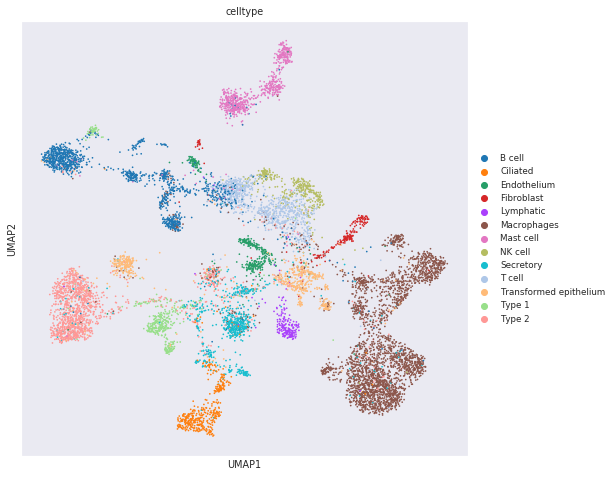

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


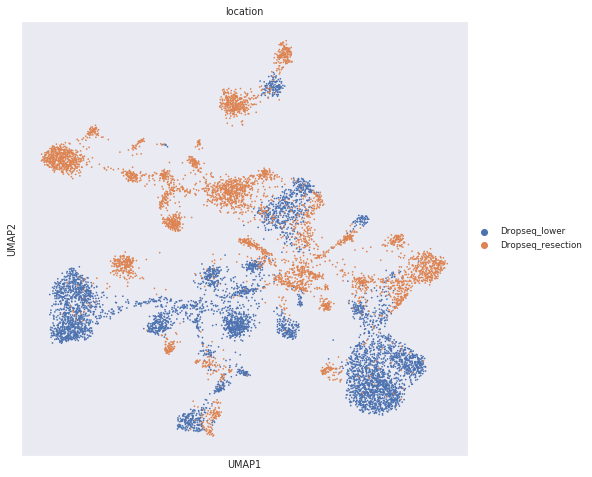

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

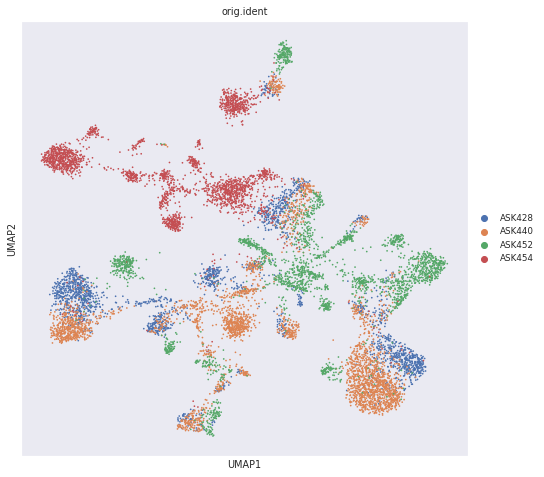

In [89]:
sc.pl.umap(datasets_ct[0], color='celltype')
sc.pl.umap(datasets_ct[0], color='location')
sc.pl.umap(datasets_ct[0], color='orig.ident')